In [1]:
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.ticker as mtick

In [14]:
from helper_functions import *

In [2]:
path = '../data/clusters/'

feature_name = 'feature_set_'
path_features = path+feature_name

inherent_name = 'inherent.csv'
non_nodal_name = 'non_nodal.csv'
feature_list = 'feature_list.csv'

In [3]:
measures = ['t1', 't2', 'degree_centrality', 'strength', 'incloseness', 'authorities', 
            'k_out', 'k_in', 'average_controllability', 'betweenness_centrality', ]

In [4]:
topics = ['ukraine', 'covid', 'costofliving', 'brexit']

In [5]:
master = pd.read_csv(path+'common_nodes_count.csv')
master['share'] = master.no_of_common_nodes/master.min_size
master = master.reset_index().rename(columns={'index': 'id'})
master.id += 1

In [6]:
def get_list_features(best, measures, id_):
    l = best.loc[best.id==id_, 'features'].values[0]
    list_ = list()
    for measure in measures:
        if measure in l:
            list_.append(measure)
    return list_

def get_lists_of_list_features(best, measures):
    list_of_lists = list()
    for id_ in best.id.values:
        list_ = get_list_features(best, measures, id_)
        list_of_lists.append(list_)
    return list_of_lists


def transform_common_nodes_to_list(best):
    list_of_lists = list()
    for id_ in best.id.values:
        string = best.loc[best.id==id_, 'common_nodes'].values[0]
        l = string.split("'")[1::2]
        len_ = best.loc[best.id==id_, 'no_of_common_nodes'].values[0]
        if (type(l) == list) and (len(l)==len_):
            list_of_lists.append(l)
        else:
            list_of_lists.append(string)
    best['common_nodes'] = list_of_lists

    return best

def get_second_group(best):
    column_name = 'second_common_nodes'
    list_of_lists = list()
    cardinalities = list()
    if column_name not in best.columns:
        for id_ in best.id.values:
            nodes = pd.read_csv(path+feature_name+str(id_)+'/'+non_nodal_name)['0'].to_list()
            len_nodes = len(nodes)
            other_nodes = best.loc[best.id==id_, 'common_nodes'].values
            if (nodes[0] in other_nodes):
                nodes = pd.read_csv(path+feature_name+str(id_)+'/'+inherent_name)['0'].to_list()
                len_nodes = len(nodes)
                
            list_of_lists.append(nodes)
            cardinalities.append(len_nodes)
            
        best[column_name] = list_of_lists
        best['no_of_'+column_name] = cardinalities
        
        return best
    else:
        print('second group of common nodes is already in best DataFrame')
        return best
    
def are_features_the_same_test(best):
    are_the_same = list()

    for id_ in best.id.values:
        df = pd.read_csv(path_features+str(id_)+'/'+feature_list, index_col=0).rename(columns={'0': 'features'})
        df = df.loc[:len(df)/2-1, 'features'].values

        list_ = np.array(best.loc[best.id==id_, 'features'].values[0])

        b = bool(np.floor(sum(np.equal(np.sort(list_),np.sort(df)))/len(df)))
        are_the_same.append(b)

    are_they = bool(np.floor(sum(are_the_same)))
    return are_they

def get_df_counts(best, measures):

    counts = np.zeros(len(measures))
    for list_ in best.features.values:
        for (i, measure) in enumerate(measures):
            if measure in list_:
                counts[i] += 1
    df_counts = pd.DataFrame()
    df_counts['measures'] = measures
    df_counts['counts'] = counts

    return df_counts

def get_mi_diff_pop_1(X,Y,niter=100):
    N,T = np.shape(X)
    M,_ = np.shape(Y)

    te_xy = []

    for z in range(niter):
        selected_idx = np.random.choice(M,size = N,replace=False)
        y = Y[selected_idx]
        xy_temp = []

        for i in range(1,T):
            txy = get_cmi(X[:,i-1],y[:,i],y[:,i-1])
            xy_temp.append(txy)
        te_xy.append(xy_temp)
    te_xy = np.mean(te_xy,axis=0)
    return te_xy


def get_share_H_Y(l_x, l_y, timeseries_weekly):
    X = timeseries_weekly.loc[timeseries_weekly.Screen_name.isin(l_x), timeseries_weekly.columns[1:]].values
    Y = timeseries_weekly.loc[timeseries_weekly.Screen_name.isin(l_y), timeseries_weekly.columns[1:]].values

    te_xy = get_mi_diff_pop_1(X, Y)

    H_Y = np.array([H(Y[:, i]) for i in range(Y.shape[1])])
    share_H_Y = [100*te_xy[i]/H_Y[i+1] if (te_xy[i]!=0) and (H_Y[i+1]!=0) else 0 for i in range(len(te_xy))]
    share_H_Y = np.array(share_H_Y)
    
    return share_H_Y

def get_share_H_exclusive(l_x, timeseries_weekly):
    X = timeseries_weekly.loc[timeseries_weekly.Screen_name.isin(l_x), timeseries_weekly.columns[1:]].values
    Y = timeseries_weekly.loc[~timeseries_weekly.Screen_name.isin(l_x), timeseries_weekly.columns[1:]].values

    te_xy, te_yx = get_mi_diff_pop(X, Y)
    
    H_X = np.array([H(X[:, i]) for i in range(X.shape[1])])
    share_H_X = [100*te_yx[i]/H_X[i+1] if (te_yx[i]!=0) and (H_X[i+1]!=0) else 0 for i in range(len(te_yx))]
    share_H_X = np.array(share_H_X)

    H_Y = np.array([H(Y[:, i]) for i in range(Y.shape[1])])
    share_H_Y = [100*te_xy[i]/H_Y[i+1] if (te_xy[i]!=0) and (H_Y[i+1]!=0) else 0 for i in range(len(te_xy))]
    share_H_Y = np.array(share_H_Y)
    
    return share_H_X, share_H_Y

def get_all_active_nodes(combinations_to_try):
    active_nodes = pd.DataFrame()

    for id_ in combinations_to_try.id.values:
        inherent = combinations_to_try.loc[combinations_to_try.id==id_, 'inherent'].values[0]
        non_nodal = combinations_to_try.loc[combinations_to_try.id==id_, 'non_nodal'].values[0]

        for topic in topics:
            for cluster in range(3):
                list_topic = pd.read_csv(path+feature_name+f'{id_}/{topic}_{cluster}.csv').Node.to_list()

                len_inter_inherent = len(set(inherent).intersection(set(list_topic)))
                len_inter_non_nodal = len(set(non_nodal).intersection(set(list_topic)))

                if (len_inter_non_nodal == 0) and (len_inter_inherent == 0):
                    active_nodes[f'{topic}_{id_}'] = [list_topic]
                    active_nodes[f'len_{topic}_{id_}'] = len(list_topic)
    return active_nodes

def get_three_clusters(id_, combinations_to_try):
    three_clusters = pd.DataFrame()
    
    inherent = combinations_to_try.loc[combinations_to_try.id==id_, 'inherent'].values[0]
    non_nodal = combinations_to_try.loc[combinations_to_try.id==id_, 'non_nodal'].values[0]
    
    for topic in topics:
        for cluster in range(3):
            list_topic = pd.read_csv(path+feature_name+f'{id_}/{topic}_{cluster}.csv').Node.to_list()

            len_inter_inherent = len(set(inherent).intersection(set(list_topic)))
            len_inter_non_nodal = len(set(non_nodal).intersection(set(list_topic)))
            
            if (len_inter_non_nodal == 0) and (len_inter_inherent == 0):
                three_clusters[f'{topic}_active'] = [list_topic]
            elif len_inter_inherent != 0:
                three_clusters[f'{topic}_inherent'] = [list_topic]
            elif len_inter_non_nodal != 0:
                three_clusters[f'{topic}_non_nodal'] = [list_topic]
    return three_clusters

def get_four_clusters(id_, combinations_to_try):
    four_clusters = pd.DataFrame()
    
    inherent = combinations_to_try.loc[combinations_to_try.id==id_, 'inherent'].values[0]
    non_nodal = combinations_to_try.loc[combinations_to_try.id==id_, 'non_nodal'].values[0]
    
    four_clusters['inherent'] = [inherent]
    
    for topic in topics:
        for cluster in range(3):
            list_topic = pd.read_csv(path+feature_name+f'{id_}/{topic}_{cluster}.csv').Node.to_list()
            
            len_inter_inherent = len(set(inherent).intersection(set(list_topic)))
            len_inter_non_nodal = len(set(non_nodal).intersection(set(list_topic)))
            
            if (len_inter_non_nodal == 0) and (len_inter_inherent == 0):
                four_clusters[f'{topic}_funnel'] = [list_topic]
            elif len_inter_inherent != 0:
                four_clusters[f'{topic}_active'] = [[node for node in list_topic if node not in inherent]]
            elif len_inter_non_nodal != 0:
                four_clusters[f'{topic}_non_nodal'] = [list_topic]
    return four_clusters

In [7]:
best = master.sort_values(by='share', ascending=False).reset_index(drop=True).loc[:7, :] #:7
list_of_lists = get_lists_of_list_features(best, measures)
best['features'] = list_of_lists
best = transform_common_nodes_to_list(best)
best = get_second_group(best)
best['no_of_total_common_nodes'] = best['no_of_common_nodes']+best['no_of_second_common_nodes']

best_ids = best.id.values

In [8]:
best = best.sort_values(by='no_of_total_common_nodes', ascending=False).reset_index(drop=True).loc[:, :]
best_ids = best.id.values

In [9]:
best.loc[best.id.isin([88, 5, 89, 96, 64])]

,id,features,common_nodes,no_of_common_nodes,min_size,share,second_common_nodes,no_of_second_common_nodes,no_of_total_common_nodes
0,88,"[t1, degree_centrality, strength]","[Direthoughts, jessphillips, AnushkaAsthana, B...",210.0,322.0,0.652174,"[andym_editor, tombrookspolloc, AWMurrison, re...",129,339.0
3,89,"[t1, degree_centrality, authorities]","[jessphillips, AnushkaAsthana, BenChu_, Shelag...",194.0,344.0,0.563953,"[CharlotteCGill, thatkirstylang, tombrookspoll...",76,270.0


In [10]:
are_features_the_same_test(best)

True

In [11]:
df_counts = get_df_counts(best, measures)
df_counts.sort_values(by='counts', ascending=False)

,measures,counts
0,t1,8.0
5,authorities,5.0
2,degree_centrality,4.0
3,strength,4.0
4,incloseness,3.0
7,k_in,3.0
6,k_out,1.0
8,average_controllability,1.0
1,t2,0.0
9,betweenness_centrality,0.0


In [12]:
num_to_try = 2

combinations_to_try = pd.DataFrame()
combinations_to_try['id'] = best.id.values[:num_to_try]

list_inherents = list()
list_len_inherents = list()
list_non_nodal = list()
list_len_non_nodal = list()

for id_ in best.id.values[:num_to_try]:
    inherents = pd.read_csv(path+feature_name+str(id_)+'/'+inherent_name)['0'].to_list()
    len_inherents = len(inherents)
    list_inherents.append(inherents)
    list_len_inherents.append(len_inherents)
    
    non_nodals = pd.read_csv(path+feature_name+str(id_)+'/'+non_nodal_name)['0'].to_list()
    len_non_nodals = len(non_nodals)
    list_non_nodal.append(non_nodals)
    list_len_non_nodal.append(len_non_nodals)
    
combinations_to_try['inherent'] = list_inherents
combinations_to_try['len_inherent'] = list_len_inherents
combinations_to_try['non_nodal'] = list_non_nodal
combinations_to_try['len_non_nodal'] = list_len_non_nodal


In [13]:
combinations_to_try

,id,inherent,len_inherent,non_nodal,len_non_nodal
0,88,"[NickTorfaen, NIAbbot, annietrev, FraserNelson...",210,"[andym_editor, tombrookspolloc, AWMurrison, re...",129
1,87,"[NickTorfaen, NIAbbot, annietrev, FraserNelson...",199,"[tombrookspolloc, MinnieStephC4, bmt44, realBe...",85


# Transfer Entropy Analysis

In [15]:
topics_list = ['', 'ukraine', '', 'covid', '', 'costofliving', 'brexit']
groups_str = ['inherent', 'active', 'funnel', 'non_nodal']

In [18]:
path_data = "../data/"
weekly_ukraine = get_weekly_activity(1, path=path_data)
weekly_covid = get_weekly_activity(3, path=path_data)
weekly_costofliving = get_weekly_activity(5, path=path_data)
weekly_brexit = get_weekly_activity(6, path=path_data)

weekly_activities = [None, weekly_ukraine, None, weekly_covid, None, weekly_costofliving, weekly_brexit]

In [19]:
id_ = 88

four_clusters = get_four_clusters(id_, combinations_to_try)

In [20]:
results_dict = dict()

for topic in [1, 3, 5, 6]:
    topic_str = topics_list[topic]
    timeseries_weekly = weekly_activities[topic]
    results_dict[topic_str] = dict()

    inherent = four_clusters[f'{groups_str[0]}'].values[0]
    active = four_clusters[topic_str+f'_{groups_str[1]}'].values[0]
    funnel = four_clusters[topic_str+f'_{groups_str[2]}'].values[0]
    non_nodal = four_clusters[topic_str+f'_{groups_str[3]}'].values[0]

    groups = [inherent, active, funnel, non_nodal]

    for (x, l_x) in enumerate(groups):
        share_H_X, share_H_Y = get_share_H_exclusive(l_x, timeseries_weekly)

        results_dict[topic_str][f"{groups_str[x]}_all"] = share_H_Y
        results_dict[topic_str][f"all_{groups_str[x]}"] = share_H_X
        
    print(topic_str+' finished')

ukraine finished
covid finished
costofliving finished
brexit finished


In [22]:
four_clusters.apply(lambda x: len(x[0]))

inherent                   210
ukraine_active             722
ukraine_non_nodal         1780
ukraine_funnel            1146
covid_non_nodal           1097
covid_funnel               641
covid_active               384
costofliving_active        189
costofliving_non_nodal     772
costofliving_funnel        424
brexit_funnel              307
brexit_non_nodal           556
brexit_active              112
dtype: int64

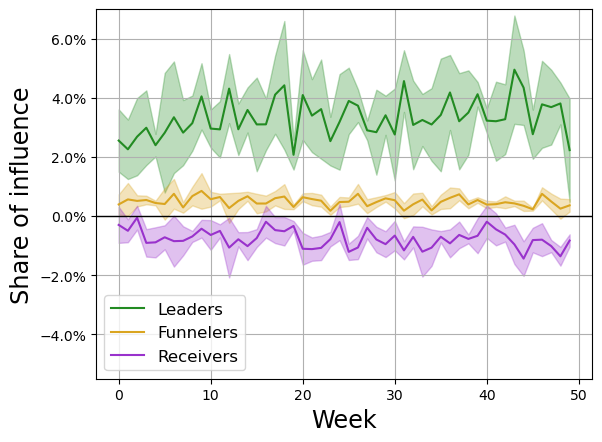

In [23]:
fig, ax = plt.subplots(1, 1)

number_weeks = len(results_dict['ukraine']['inherent_all'])
number_topics = 4
#colors = [cmap(0.0), cmap(0.3), cmap(0.8), cmap(0.3)]
colors = ['forestgreen','', 'goldenrod','darkorchid']
labels = ["Leaders", "", "Funnelers", "Receivers"]

groups_str = ['inherent', 'active', 'non_nodal', 'funnel']

for (idx, group) in enumerate(groups_str):
    diffs = np.zeros((number_topics, number_weeks-1))
        
    if idx != 1:
        for (idx_topic, topic) in enumerate([1, 3, 5, 6]):
            topic_str = topics_list[topic]
            diff = results_dict[topic_str][group+'_all'][:-1]-results_dict[topic_str]['all_'+group][:-1]
            diffs[idx_topic, :] = diff

        ax.plot(diffs.mean(axis=0), '-', linewidth=1.5, label=labels[idx], color=colors[idx])
        ax.fill_between(np.arange(50),
                          diffs.mean(axis=0)-diffs.std(axis=0), 
                          diffs.mean(axis=0)+diffs.std(axis=0),
                          alpha=0.3, color=colors[idx])
        
plt.grid()
ax.legend(fontsize='large')
ax.set_ylim(ymin=-5.5, ymax=7)

ax.set_ylabel("Share of influence", size="xx-large")
ax.set_xlabel("Week", size="xx-large")

ax.axhline(y=0, color='k', linewidth=1.)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())        

#plt.savefig("Figures/nodality_groups.png", format="png", bbox_inches='tight', transparent=True)